<a href="https://colab.research.google.com/github/Pyeonseohee/Deeplearning/blob/main/Deepnoid_Lecture04_SSD_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Move root working directory
!cd /content/

# Clone a source from git
!git clone --recursive https://github.com/juny-park-95/tf_ssd.git

# Note that : SSD + VGG16 Backbone is too old! To be honesty, No one want to use the vgg model.
# Although the lecture does not cope with another backbone networks with SSD, however, 
# I highly recommend SSD + Latest backbone models for your future study, such as :
# https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md

Cloning into 'tf_ssd'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 74 (delta 22), reused 58 (delta 11), pack-reused 0
Unpacking objects: 100% (74/74), done.


*   Change working directory & load packages

In [3]:
# Move into model directory,
%cd /content/tf_ssd

# Unfortunately, since our time is limited,  I'll leave training schemes as additional stuffs in this lecture.
# In order to train/verify training networks, you guys can draw loss graph and analize loss convergence as well.
# I recommend the tensorboard for your training experience.
# %load_ext tensorboard
# %tensorboard --logdir=$(Log path here) # Ex) %tensorboard --logdir=/content/logs/

# Once you guys exploits the tensorboard in your working environemnt, like
# tensorboard --logdir=($Current_Training_log_directory) --bind_all
# You can easily analize training stuffs such as training tendency from the log graph, architecture, etc.
%matplotlib inline
# !python predictor.py --backbone vgg16 --out_path /content/tf_ssd/results --use_custom True --custom_path /content/tf_ssd/datasets/custom

/content/tf_ssd


# A training loss graph by using tensorBoard
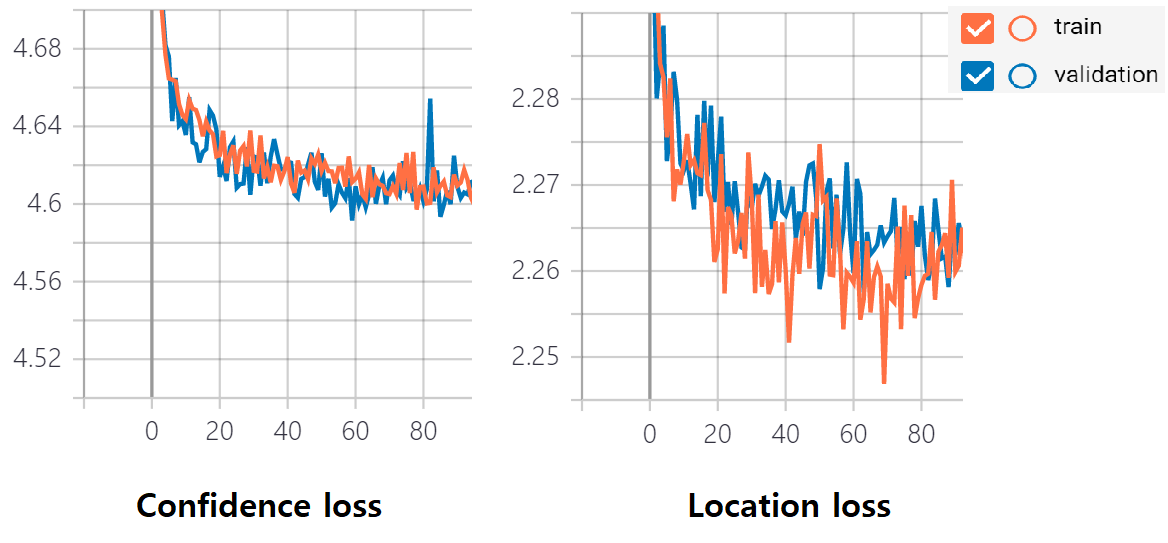

In [4]:
# Import python modules
import tensorflow as tf
from utils import bbox_utils, data_utils, drawing_utils, io_utils, train_utils, eval_utils
from models.decoder import get_decoder_model

# Deprecated
# if args.handle_gpu:
#     io_utils.handle_gpu_compatibility()

batch_size = 32
evaluate = False

# Inference custom images
use_custom_images = True
if use_custom_images:
    custom_image_path = "/content/tf_ssd/datasets/custom"

# You can use not only vgg16 in original SSD paper, but also custom backbone like mobileNet.
backbone = "vgg16"
io_utils.is_valid_backbone(backbone)

if backbone == "mobilenet_v2":
    from models.ssd_mobilenet_v2 import get_model, init_model
else:
    from models.ssd_vgg16 import get_model, init_model
hyper_params = train_utils.get_hyper_params(backbone)

# Set the test datasets, original : voc 2007
test_data, info = data_utils.get_dataset("voc/2007", "test")
total_items = data_utils.get_total_item_size(info, "test")

labels = data_utils.get_labels(info)
labels = ["bg"] + labels
hyper_params["total_labels"] = len(labels)
img_size = hyper_params["img_size"]
data_types = data_utils.get_data_types()
data_shapes = data_utils.get_data_shapes()
padding_values = data_utils.get_padding_values()

Shuffling and writing examples to /content/drive/MyDrive/tensorflow_datasets/voc/2007/4.0.0.incomplete4S779A/voc-test.tfrecord


Shuffling and writing examples to /content/drive/MyDrive/tensorflow_datasets/voc/2007/4.0.0.incomplete4S779A/voc-train.tfrecord


Shuffling and writing examples to /content/drive/MyDrive/tensorflow_datasets/voc/2007/4.0.0.incomplete4S779A/voc-validation.tfrecord


Dataset voc downloaded and prepared to /content/drive/MyDrive/tensorflow_datasets/voc/2007/4.0.0. Subsequent calls will reuse this data.


In [5]:
labels

['bg',
 'aeroplane',
 'bicycle',
 'bird',
 'boat',
 'bottle',
 'bus',
 'car',
 'cat',
 'chair',
 'cow',
 'diningtable',
 'dog',
 'horse',
 'motorbike',
 'person',
 'pottedplant',
 'sheep',
 'sofa',
 'train',
 'tvmonitor']

In [6]:
if use_custom_images:
    img_paths = data_utils.get_custom_imgs(custom_image_path)
    total_items = len(img_paths)
    test_data = tf.data.Dataset.from_generator(lambda: data_utils.custom_data_generator(
                                               img_paths, img_size, img_size), data_types, data_shapes)
else:
    test_data = test_data.map(lambda x : data_utils.preprocessing(x, img_size, img_size, evaluate=evaluate))

test_data = test_data.padded_batch(batch_size, padded_shapes=data_shapes, padding_values=padding_values)
print(custom_image_path)
print(total_items)

/content/tf_ssd/datasets/custom
2


In [9]:
ssd_model = get_model(hyper_params)
ssd_model_path = io_utils.get_model_path(backbone)
ssd_model.load_weights("/content/tf_ssd/weights/ssd_vgg16.h5")

prior_boxes = bbox_utils.generate_prior_boxes(hyper_params["feature_map_shapes"], hyper_params["aspect_ratios"])
ssd_decoder_model = get_decoder_model(ssd_model, prior_boxes, hyper_params)

step_size = train_utils.get_step_size(total_items, batch_size)
pred_bboxes, pred_labels, pred_scores = ssd_decoder_model.predict(test_data, steps=step_size, verbose=1)
print(pred_labels)

outPath = "/content/tf_ssd/results"
if evaluate:
    eval_utils.evaluate_predictions(test_data, pred_bboxes, pred_labels, pred_scores, labels, batch_size)
else:
    drawing_utils.draw_predictions(test_data, pred_bboxes, pred_labels, pred_scores, labels, batch_size, outPath)

OSError: ignored